# Part 1: Wrangling

In [29]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
pd.reset_option('display.max_rows')

In [4]:
sqlite_file = 'lahman2014.sqlite'
conn = sql.connect(sqlite_file)

salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"

team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


### Problem 1

In [5]:
teams_query = "SELECT yearID, teamID, franchID, W, G, W/(G*100) FROM Teams"

teams = pd.read_sql(teams_query, conn)
teams

,yearID,teamID,franchID,W,G,W/(G*100)
0,1871,BS1,BNA,20,31,0
1,1871,CH1,CNA,19,28,0
2,1871,CL1,CFC,10,29,0
3,1871,FW1,KEK,7,19,0
4,1871,NY2,NNA,16,33,0
...,...,...,...,...,...,...
2770,2014,PIT,PIT,88,162,0
2771,2014,SDN,SDP,77,162,0
2772,2014,SFN,SFG,88,162,0
2773,2014,SLN,STL,90,162,0


In [6]:
sal_query = "SELECT yearID, teamID, SUM(salary) FROM Salaries GROUP BY yearID, teamID"

sal = pd.read_sql(sal_query, conn)
sal

,yearID,teamID,SUM(salary)
0,1985,ATL,14807000.0
1,1985,BAL,11560712.0
2,1985,BOS,10897560.0
3,1985,CAL,14427894.0
4,1985,CHA,9846178.0
...,...,...,...
855,2014,SLN,120693000.0
856,2014,TBA,72689100.0
857,2014,TEX,112255059.0
858,2014,TOR,109920100.0


In [28]:
teams_query = """
                SELECT 
                    A.yearID, 
                    A.teamID, 
                    franchID,   
                    W, 
                    G, 
                    100*CAST(W AS float)/CAST(G AS float) AS winPercent,
                    payroll
                FROM 
                    Teams A
                INNER JOIN 
                    (SELECT yearID, teamID, SUM(salary) AS payroll FROM Salaries GROUP BY yearID, teamID) B 
                ON
                    A.yearID = B.yearID AND A.teamId = B.teamId
            """

teams = pd.read_sql(teams_query, conn)
teams

,yearID,teamID,franchID,W,G,winPercent,payroll
0,1985,ATL,ATL,66,162,40.740741,14807000.0
1,1985,BAL,BAL,83,161,51.552795,11560712.0
2,1985,BOS,BOS,81,163,49.693252,10897560.0
3,1985,CAL,ANA,90,162,55.555556,14427894.0
4,1985,CHA,CHW,85,163,52.147239,9846178.0
...,...,...,...,...,...,...,...
853,2014,SLN,STL,90,162,55.555556,120693000.0
854,2014,TBA,TBD,77,162,47.530864,72689100.0
855,2014,TEX,TEX,67,162,41.358025,112255059.0
856,2014,TOR,TOR,83,162,51.234568,109920100.0


# Part 2: Exploratory Data Analysis

## Payroll Distribution

### Problem 2

array([<AxesSubplot:title={'center':'payroll'}>], dtype=object)

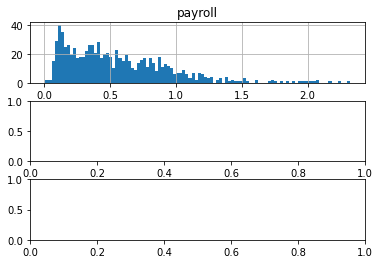

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=1)
teams.hist(column="payroll", bins=100, ax=axes[0])